In [28]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [29]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [30]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Other Chicken,Turkey,Red Meat,Poultry
0,1921-01,3.580000e+08,27000000.0,5.650000e+08,44000000.0,NaN,NaN,393000000.0,9.940000e+08,3.930000e+08
1,1921-02,2.790000e+08,24000000.0,4.840000e+08,39000000.0,NaN,NaN,NaN,8.260000e+08,0.000000e+00
2,1921-03,3.400000e+08,31000000.0,3.720000e+08,45000000.0,NaN,NaN,NaN,7.880000e+08,0.000000e+00
3,1921-04,3.160000e+08,29000000.0,3.740000e+08,41000000.0,NaN,NaN,NaN,7.600000e+08,0.000000e+00
4,1921-05,3.190000e+08,31000000.0,3.960000e+08,37000000.0,NaN,NaN,NaN,7.830000e+08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0,4.638900e+09,4.362100e+09


In [31]:
# DIR_SUBJECT_2 = '../udataset/unemployment_month_US.csv'
# DIR_SUBJECT_2 = '../dataset/youth_unemployment_rate.csv'
DIR_SUBJECT_2 = '../dataset/national_hourly_earnings.csv'
df_subject2 = pd.read_csv(DIR_SUBJECT_2)
df_subject2

,YearMonth,HourlyEarnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Make variables for specific dataset 1

In [32]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
648,1977-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
649,1977-02,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
650,1977-03,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
651,1977-04,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
652,1977-05,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 2

In [33]:
# # For unemployment_month_US.csv
# df_subject2 = df_subject2.rename(columns={'Year-Month': 'datetime'})
# SUBJECT2 = 'unemployment_rate'

# # For youth_unemployment_rate.csv
# df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'UnemploymentRate': 'unemployment_rate'})
# SUBJECT2 = 'unemployment_rate'

# For national_hourly_earnings.csv
df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'HourlyEarnings': 'hourly_earnings'})
SUBJECT2 = 'hourly_earnings'

SUBJECT_TITLE2 = SUBJECT2.replace('_', ' ').title()
df_subject2

,datetime,hourly_earnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Change label format to be lower + underscores instead of space

In [34]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')
df_subject2.columns = df_subject2.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [35]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject2['datetime'] = pd.to_datetime(df_subject2['datetime'])
df_subject2

,datetime,hourly_earnings
0,2006-03-01,20.07
1,2006-04-01,20.36
2,2006-05-01,20.06
3,2006-06-01,20.04
4,2006-07-01,20.28
...,...,...
212,2023-11-01,34.08
213,2023-12-01,34.26
214,2024-01-01,34.67
215,2024-02-01,34.61


In [36]:
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,1977-01-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
1,1977-02-01,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
2,1977-03-01,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
3,1977-04-01,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
4,1977-05-01,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
551,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
552,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
553,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
554,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


# Stationary analysis

Check for stationarity

In [37]:
def test_stationarity(timeseries, title, verbose=False):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    if verbose:
        # Print the results in a more structured report format
        print(f"Augmented Dickey-Fuller Test Results for {title}:")
        print("-------------------------------------")
        print(f"Test Statistic: {adf_stat:.4f}")
        print(f"P-value: {p_val:.4f}")
        print(f"Number of Lags Used: {used_lag}")
        print(f"Number of Observations Used: {n_obs}")
        print("Critical Values:")
        for key, value in critical_val.items():
            print(f"    {key} ({value:.4f})")
        print(f"Information Criterion (best): {icbest:.4f}")
        print("Conclusion:")
        if p_val < 0.05:
            print("The time series is stationary with 95% confidence.")
        else:
            print("The time series is not stationary. Consider differencing or detrending.")

    if p_val < 0.05:
        return 1
    else:
        return 0

# ARIMA

Split train test data

In [38]:
MAIN_MEAT = 'beef'
diff_meat = df_subject1.copy()
diff_meat = diff_meat[['datetime', MAIN_MEAT]]
diff_meat[MAIN_MEAT] = diff_meat[MAIN_MEAT].diff().diff()
diff_meat.dropna(inplace=True)
diff_meat

,datetime,beef
2,1977-03-01,323000000.0
3,1977-04-01,-379000000.0
4,1977-05-01,193000000.0
5,1977-06-01,177000000.0
6,1977-07-01,-380000000.0
...,...,...
551,2023-08-01,475800000.0
552,2023-09-01,-467200000.0
553,2023-10-01,401100000.0
554,2023-11-01,-239700000.0


In [39]:
merged_df = df_subject2.merge(diff_meat, on='datetime', how='inner')
train_df = merged_df[merged_df['datetime'].dt.year <= 2017]
test_df = merged_df[(merged_df['datetime'].dt.year > 2017) & (merged_df['datetime'].dt.year <= 2018)]

print(train_df.shape, test_df.shape)
print(merged_df)

(142, 3) (12, 3)
      datetime  hourly_earnings         beef
0   2006-03-01            20.07  594600000.0
1   2006-04-01            20.36 -605400000.0
2   2006-05-01            20.06  568600000.0
3   2006-06-01            20.04 -198800000.0
4   2006-07-01            20.28 -368600000.0
..         ...              ...          ...
209 2023-08-01            33.72  475800000.0
210 2023-09-01            33.96 -467200000.0
211 2023-10-01            34.27  401100000.0
212 2023-11-01            34.08 -239700000.0
213 2023-12-01            34.26  -34900000.0

[214 rows x 3 columns]


Do ARIMA for beef in forecasting wages

In [60]:
y = train_df[SUBJECT2]
x = train_df[MEAT_TYPE[0]]

p, d, q = 1, 2, 3
P, D, Q, s = 3, 1, 1, 12

model = SARIMAX(y, exog=x,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True)
model_fit = model.fit(disp=0)
# print(model_fit.plot_diagnostics(figsize=(12, 7)))

In [41]:
forecast = model_fit.get_forecast(steps=len(test_df), exog=test_df[MEAT_TYPE[0]])
predict_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()
print(f'predict_mean: {predict_mean}, train_df: {train_df[SUBJECT2]}')

predict_mean: 142    26.984884
143    26.905886
144    26.842700
145    27.103185
146    26.852565
147    26.753255
148    27.054142
149    26.915135
150    27.188665
151    27.312132
152    27.233240
153    27.313196
Name: predicted_mean, dtype: float64, train_df: 0      20.07
1      20.36
2      20.06
3      20.04
4      20.28
       ...  
137    26.17
138    26.46
139    26.62
140    26.47
141    26.58
Name: hourly_earnings, Length: 142, dtype: float64


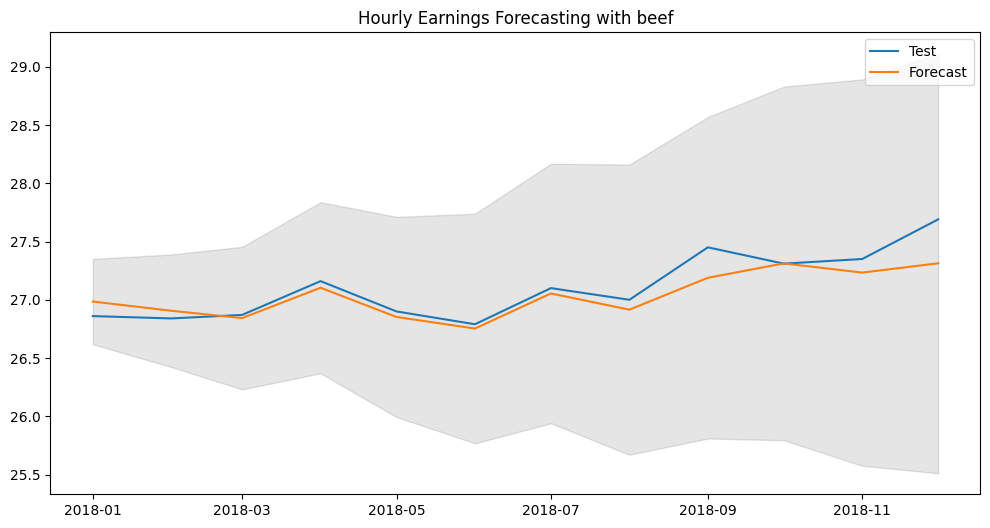

In [42]:
plt.figure(figsize=(12, 6))
# plt.plot(train_df['datetime'], train_df[SUBJECT2], label='Train')
plt.plot(test_df['datetime'], test_df[SUBJECT2], label='Test')
plt.plot(test_df['datetime'], predict_mean, label='Forecast')
plt.fill_between(test_df['datetime'], confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='k', alpha=0.1)
plt.title(f'{SUBJECT_TITLE2} Forecasting with {MEAT_TYPE[0]}')
plt.legend()
plt.show()

Calculate MAE

In [43]:
np.abs(test_df[SUBJECT2] - predict_mean).mean()

0.10390149385357834

Do grid-seach to find best MAE

In [63]:
def grid_search(endog, exog, test_endog, test_exog, search_depth=3):
    y = endog
    x = exog
    param_grid = {
        'ord_p': range(0, 2),
        'ord_q': range(0, 2),
        'season_p': range(0, 2),
        'season_d': range(0, 2),
        'season_q': range(0, 2),
        'opt': ['lbfgs', 'nm', 'powell']
    }
    parameter_combinations = list(product(*param_grid.values()))
    best_params = None
    best_mae = float('inf')
    for param in parameter_combinations:
        model = SARIMAX(y, x,
                        order=(param[0], 2, param[1]),
                        seasonal_order=(param[2], param[3], param[4], s),
                        enforce_stationarity=True,
                        enforce_invertibility=True)
        model_fit = model.fit(disp=0, method=param[5])
        forecast = model_fit.get_forecast(steps=len(test_df), exog=test_exog)
        predict_mean = forecast.predicted_mean
        cur_mae = np.abs(test_endog - predict_mean).mean()
        if cur_mae < best_mae:
            best_mae = cur_mae
            best_params = param
            print(f'Best MAE: {best_mae}, best params: {best_params} so far')

    return (best_params, best_mae)

best_param, best_mae = grid_search(endog=train_df[SUBJECT2],
                                   exog=train_df[MEAT_TYPE[0]],
                                   test_exog=test_df[MEAT_TYPE[0]],
                                   test_endog=test_df[SUBJECT2],
                                   search_depth=2)
print(best_param, best_mae)

Best MAE: 0.2433333314497279, best params: (0, 0, 0, 0, 0, 'lbfgs') so far
Best MAE: 0.22796257604170922, best params: (0, 0, 0, 0, 1, 'lbfgs') so far
Best MAE: 0.227959262088589, best params: (0, 0, 0, 0, 1, 'nm') so far
Best MAE: 0.21058797748084027, best params: (0, 0, 0, 1, 1, 'lbfgs') so far
Best MAE: 0.21057047959117448, best params: (0, 0, 0, 1, 1, 'powell') so far


/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invert

Best MAE: 0.20429966697080992, best params: (0, 1, 0, 0, 0, 'nm') so far
Best MAE: 0.12770809213550974, best params: (0, 1, 0, 0, 1, 'lbfgs') so far
Best MAE: 0.10799695578851409, best params: (0, 1, 0, 0, 1, 'nm') so far


/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invert

Best MAE: 0.07837666057736985, best params: (0, 1, 1, 0, 0, 'nm') so far


/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invert

(0, 1, 1, 0, 0, 'nm') 0.07837666057736985


(0, 0, 1, 1, 1, 'powell') 0.07962393650929804
